# Import Libraries

In [4]:
import warnings
warnings.filterwarnings("ignore")

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Data Loading

In [5]:
base_dir = 'phase_2_data'
class_labels = os.listdir(base_dir)
class_labels.sort()

print(class_labels)

['Abnormal', 'Normal']


In [6]:
chart_data = []

for target in class_labels:
    path = os.path.join(base_dir,target)
    size = len(os.listdir(path))
    chart_data.append(size)
    print(f'The target {target:<10} has ({size}) samples in the dataset')

The target Abnormal   has (1104) samples in the dataset
The target Normal     has (324) samples in the dataset


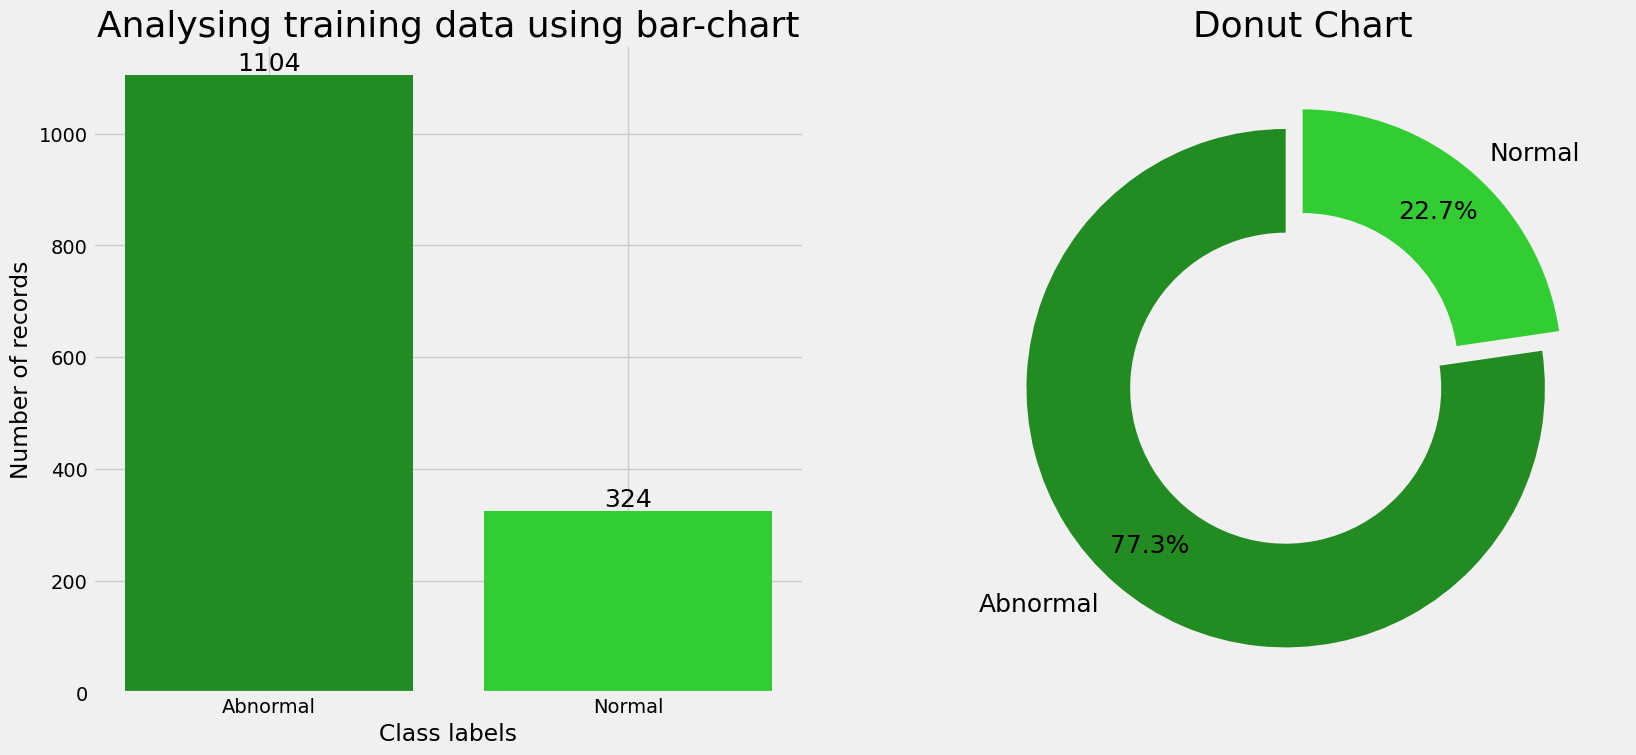

In [7]:
with plt.style.context(style="fivethirtyeight"):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
    plt.rcParams["font.size"] = 18

    ax1.bar(x=class_labels,
            height=chart_data,
            color=["forestgreen", "limegreen", "darkgreen", "green", "lime"])

    for i, value in enumerate(chart_data):
        ax1.text(i, value + 1, str(value), ha='center', va='bottom')

    ax1.set_title("Analysing training data using bar-chart")
    ax1.set_xlabel("Class labels")
    ax1.set_ylabel("Number of records")
    sizes = np.array(chart_data)
    explode = [0.1] + [0] * (len(sizes) - 1)

    ax2.pie(sizes, labels=class_labels, autopct='%1.1f%%', startangle=90, colors=["forestgreen", "limegreen", "darkgreen", "green", "lime"],
            wedgeprops=dict(width=0.4), explode=explode, pctdistance=0.80)

    ax2.set_title("Donut Chart")

    plt.show()

In [8]:
data = []
labels = []

for idx, target in enumerate(class_labels):
    path = os.path.join(base_dir, target)
    image_names = os.listdir(path)
    for image_name in tqdm(image_names, desc=f'Loading {target} images', total=len(image_names)):
        image_path = os.path.join(path, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        image = np.array(image)
        image = image/255.0
        data.append(image)
        labels.append(idx)

Loading Normal images: 100%|██████████| 324/324 [00:07<00:00, 44.18it/s] 


In [9]:
data = np.array(data)
labels = np.array(labels)

print(data.shape, labels.shape)

(1428, 224, 224, 3) (1428,)


In [10]:
def show_images(X,y,class_names):
    plt.figure(figsize=(10, 10))
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        idx = random.randint(0, X.shape[0]-1)
        plt.imshow(X[idx])
        plt.axis("off")
        plt.title("Class:{}".format(class_names[y[idx]]))
    plt.tight_layout()
    plt.show()

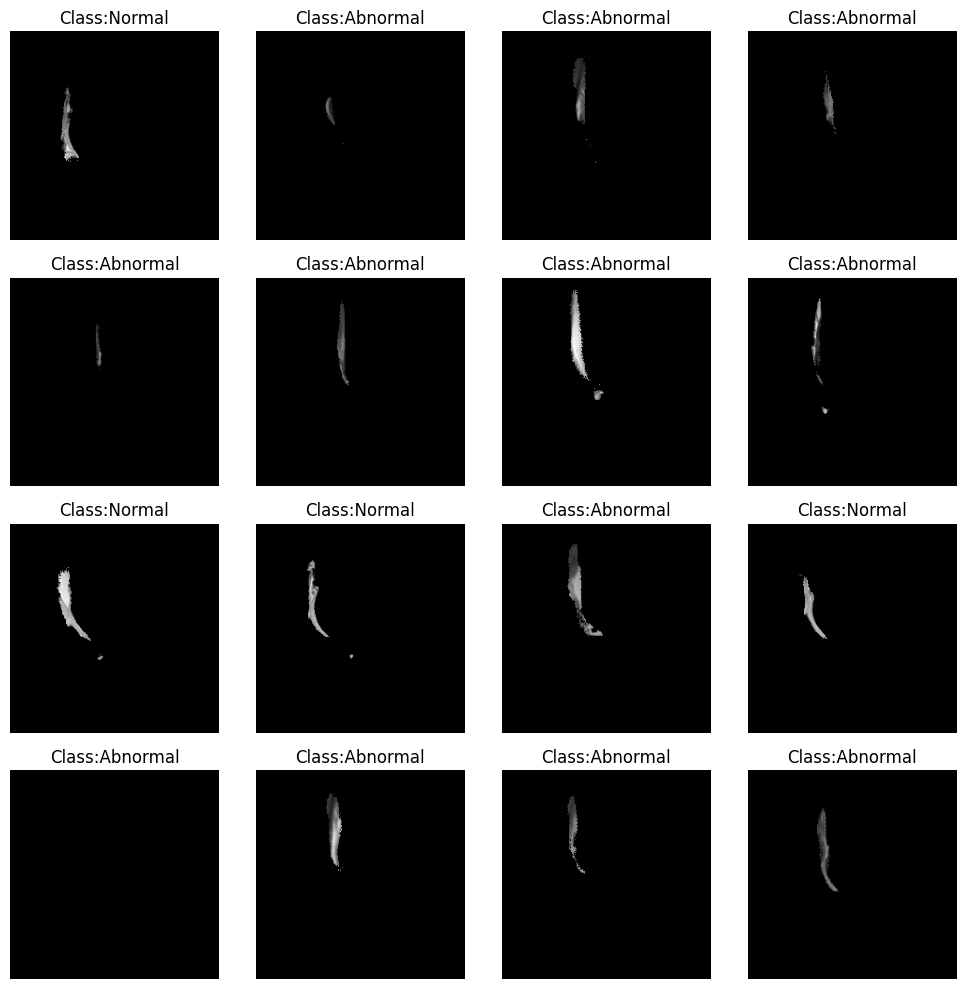

In [11]:
show_images(data,labels,class_labels)

In [12]:
labels = to_categorical(labels)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=seed_value)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1142, 224, 224, 3) (286, 224, 224, 3) (1142, 2) (286, 2)


---

# Algorithm: DenseNet201

In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [14]:
densenet_model = tf.keras.applications.DenseNet201(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling="max",
    classes=1000
)

densenet_model.trainable = False

74836368/74836368 [==============================] - 4s 0us/step


In [15]:
inputs = densenet_model.input
dropout = tf.keras.layers.Dropout(rate=0.4)(densenet_model.output)
fc1 = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.L1(l1=0.01))(dropout)
fc2 = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L1(l1=0.01))(fc1)
fc3 = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L1(l1=0.01))(fc2)
outputs = tf.keras.layers.Dense(len(class_labels), activation='sigmoid')(fc3)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [16]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']      

In [17]:
EPOCHS = 20

history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    callbacks=[ReduceLROnPlateau(monitor='val_accuracy', patience=2, min_lr=0)]
)

Epoch 1/20
36/36 [==============================] - 42s 635ms/step - loss: 346.1499 - accuracy: 0.8634 - val_loss: 106.5849 - val_accuracy: 0.9580 - lr: 0.0010
Epoch 2/20
36/36 [==============================] - 6s 177ms/step - loss: 46.8701 - accuracy: 0.8757 - val_loss: 15.1972 - val_accuracy: 0.8287 - lr: 0.0010
Epoch 3/20
36/36 [==============================] - 6s 177ms/step - loss: 8.5783 - accuracy: 0.8406 - val_loss: 5.2316 - val_accuracy: 0.8531 - lr: 0.0010
Epoch 4/20
36/36 [==============================] - 6s 178ms/step - loss: 2.7481 - accuracy: 0.8520 - val_loss: 1.8476 - val_accuracy: 0.8531 - lr: 1.0000e-04
Epoch 5/20
36/36 [==============================] - 6s 179ms/step - loss: 1.7064 - accuracy: 0.8748 - val_loss: 1.6029 - val_accuracy: 0.8357 - lr: 1.0000e-04
Epoch 6/20
36/36 [==============================] - 6s 181ms/step - loss: 1.3824 - accuracy: 0.8555 - val_loss: 1.3023 - val_accuracy: 0.8392 - lr: 1.0000e-05
Epoch 7/20
36/36 [==============================] -

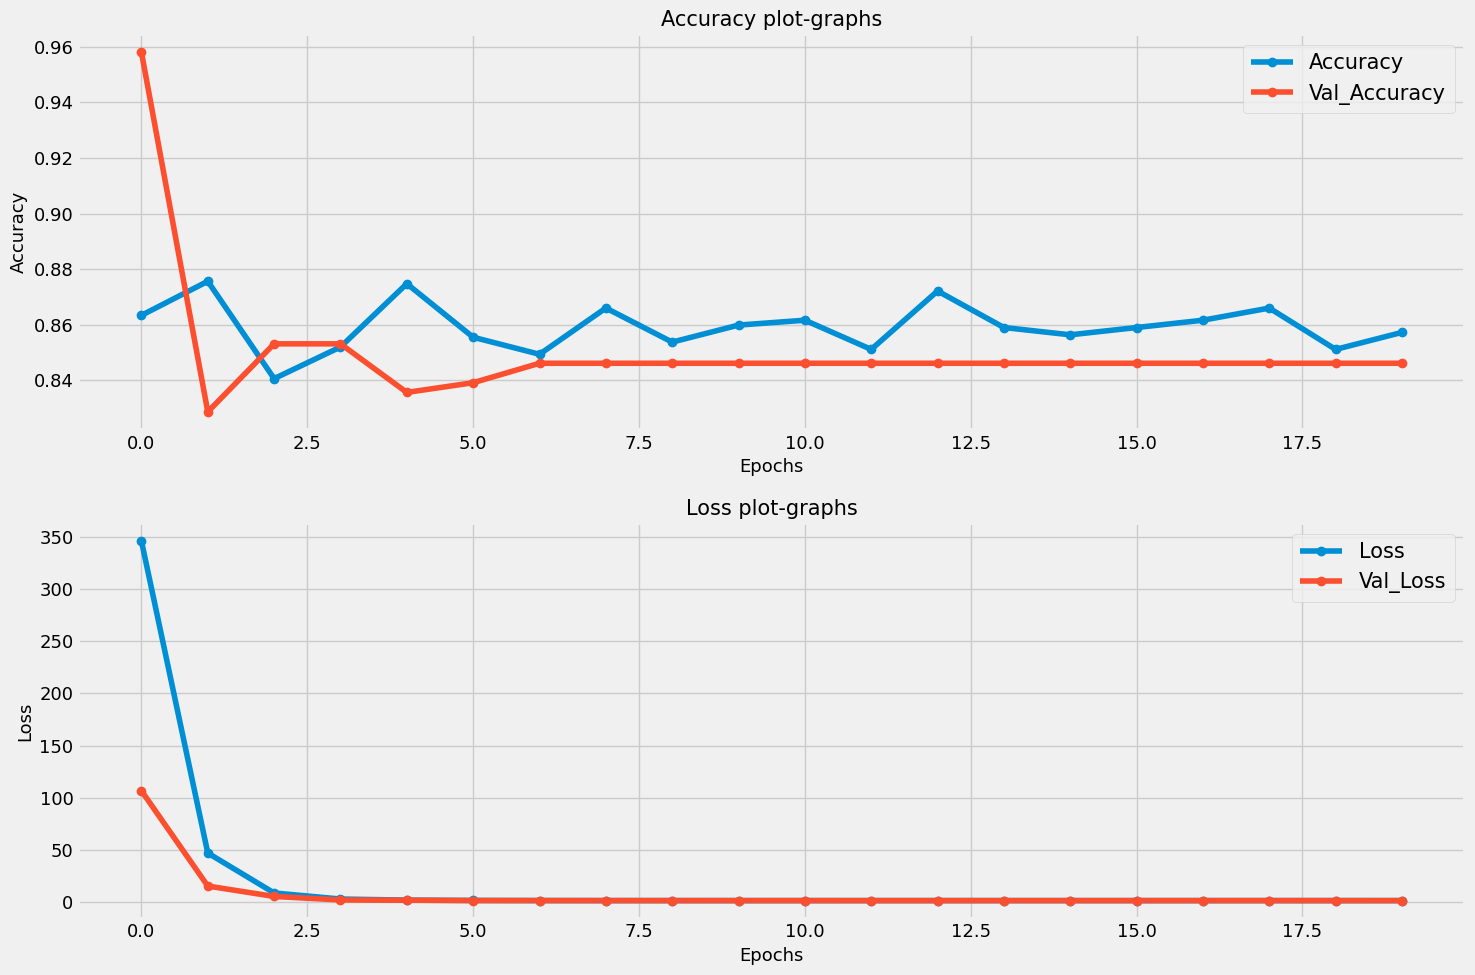

In [18]:
with plt.style.context(style="fivethirtyeight"):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
    plt.rcParams["font.size"] = 15

    axes[0].plot(history.history['accuracy'], label='Accuracy', marker='o')
    axes[0].plot(history.history['val_accuracy'], label='Val_Accuracy', marker='o')
    axes[0].set_title(label='Accuracy plot-graphs', fontsize=15)
    axes[0].set_xlabel(xlabel='Epochs', fontsize=13)
    axes[0].set_ylabel(ylabel='Accuracy', fontsize=13)
    axes[0].tick_params(axis='both', which='major', labelsize=13)
    axes[0].legend()

    axes[1].plot(history.history['loss'], label='Loss', marker='o')
    axes[1].plot(history.history['val_loss'], label='Val_Loss', marker='o')
    axes[1].set_title(label='Loss plot-graphs', fontsize=15)
    axes[1].set_xlabel(xlabel='Epochs', fontsize=13)
    axes[1].set_ylabel(ylabel='Loss', fontsize=13)
    axes[1].tick_params(axis='both', which='major', labelsize=13)
    axes[1].legend()

    fig.tight_layout()
    plt.show()

In [19]:
model_prediction = model.predict(X_test, batch_size=32, verbose=1)
print(model_prediction)

9/9 [==============================] - 4s 125ms/step
[[0.72423583 0.2710013 ]
 [0.7073201  0.28819203]
 [0.9371449  0.0543586 ]
 [0.827716   0.16124398]
 [0.9299248  0.06105693]
 [0.94797176 0.04450082]
 [0.93929774 0.05234688]
 [0.97196746 0.02294473]
 [0.91242725 0.07778335]
 [0.9584033  0.03496211]
 [0.7942279  0.19754839]
 [0.82352626 0.16577087]
 [0.47169995 0.54491216]
 [0.889872   0.09984916]
 [0.92781466 0.06303983]
 [0.48001704 0.5343535 ]
 [0.9231854  0.0674345 ]
 [0.91883993 0.07161908]
 [0.7534894  0.23830745]
 [0.9134129  0.07662769]
 [0.9135865  0.07663815]
 [0.9378903  0.05364884]
 [0.58455837 0.42185906]
 [0.7287853  0.26552242]
 [0.8260575  0.16141859]
 [0.82837194 0.15917973]
 [0.89287424 0.09722075]
 [0.9083998  0.08191326]
 [0.4901222  0.5238798 ]
 [0.87496215 0.11364002]
 [0.8593325  0.13043086]
 [0.90364414 0.08635687]
 [0.65969235 0.33741507]
 [0.960709   0.03291351]
 [0.93183833 0.05939516]
 [0.63314956 0.36621368]
 [0.9168528  0.07335053]
 [0.7664211  0.2237536

In [20]:
pred = np.argmax(model_prediction, axis=1)
print(pred.tolist())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]


In [21]:
actual = np.argmax(y_test, axis=1)
print(actual.tolist())

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1]


### Result Analysis

In [22]:
model_accuracy = accuracy_score(y_true=actual, y_pred=pred)
print(f"Validation accuracy of DenseNet201 model is {model_accuracy*100.0:.2f}%")

Validation accuracy of DenseNet201 model is 84.62%


***Classification Report***

In [23]:
print(classification_report(y_true=actual, y_pred=pred, target_names=class_labels))

              precision    recall  f1-score   support

    Abnormal       0.83      1.00      0.91       218
      Normal       1.00      0.35      0.52        68

    accuracy                           0.85       286
   macro avg       0.92      0.68      0.72       286
weighted avg       0.87      0.85      0.82       286



***Confusion Matrix***

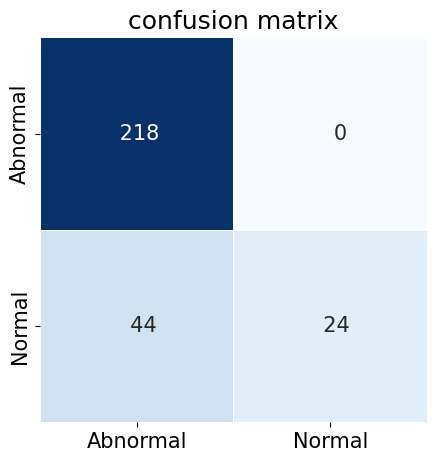

In [24]:
plt.figure(figsize=(5,5))
plt.rcParams['font.size']=15
sns.heatmap(
    data=confusion_matrix(y_true=actual, y_pred=pred),
    annot=True,
    fmt='4d',
    cbar=False,
    xticklabels=class_labels,
    yticklabels=class_labels,
    cmap=plt.cm.Blues,
    linewidths=0.5,
    linecolor='white'
)
plt.title(label='confusion matrix')
plt.show()

***model saving***

In [25]:
model.save("model/DenseNet201_model.h5")